In [347]:
import os
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [348]:
import numpy as np

from matplotlib import pyplot as plt

import json

import utils

from modules import helpers, fitting

import importlib
importlib.reload(utils)
importlib.reload(helpers)
importlib.reload(fitting)

helpers.set_plot_configs()

In [349]:
calibration = utils.MCACalibration('data/2025-03-04/Calibration_recoil_na_0304.Spe',
                                   'data/2025-03-04/Calibration_recoil_ba_0304.Spe',
                                   kernel_bw=5,cs_137_approx_line_bin=1800,)

In [350]:
DataReader = utils.MCAData()

def show_calibration_spectrum(ax,sub_ax,isotope='na',file_base=['data/2025-03-04/Calibration_recoil_','_0304.Spe'],
                              kernel_bw=5,cs_137_approx_line_bin=1800,
                              ylim=[0,8000],xlabel=None):
    # Process data
    bins, counts, _, _ = DataReader._read_data(file_base[0]+isotope+file_base[1])
    normalizing_factor = np.sum(counts) * (bins[1] - bins[0])
    kde_bins, kdes, kdes_err = DataReader._kde_smooth_data(bins, counts, bw=kernel_bw)
    peaks_idx, valleys_idx = DataReader._find_peaks_and_valleys(kde_bins, kdes, kdes_err)

    calibration = utils.MCACalibration(file_base[0]+'na'+file_base[1],file_base[0]+'ba'+file_base[1],
                                       kernel_bw=kernel_bw,cs_137_approx_line_bin=cs_137_approx_line_bin,)

    # Plot spectrum
    ax.plot(bins, counts, color='darkcyan', label='Spectrum' if isotope == 'na' else None)
    ax.plot(kde_bins, kdes*normalizing_factor, color='darkblue', ls='--', label='KDE' if isotope == 'na' else None)

    # for peak_idx in peaks_idx:
    #     ax.axvline(kde_bins[peak_idx], color='darkblue', ls='--', dashes=(1.5,2), lw=2)
    # for valley_idx in valleys_idx:
    #     ax.axvline(kde_bins[valley_idx], color='chocolate', ls='--', dashes=(1.5,2), lw=2)

    if isotope == 'na':
        peaks_mu = list(calibration.na_22_peak_mu)
        peaks_fitting_bins = [calibration.na_22_fitting_bins]
        peaks_fitted_counts = [calibration.na_22_fitted_counts]
    if isotope == 'ba':
        peaks_mu = []
        for mus in calibration.ba_133_peaks_mu:
            peaks_mu += list(mus)
        peaks_mu += list(calibration.cs_137_peak_mu)
        peaks_fitting_bins = calibration.ba_133_fitting_bins + [calibration.cs_137_fitting_bins]
        peaks_fitted_counts = calibration.ba_133_fitted_counts + [calibration.cs_137_fitted_counts]

    for i, (fitting_bins, fitted_counts) in enumerate(zip(peaks_fitting_bins, peaks_fitted_counts)):
        ax.plot(fitting_bins,fitted_counts, color='maroon', ls='-', lw=3, label='Peak Fits' if isotope == 'na' and not i else None)
        # ax.axvline(fitting_bins[0], color='maroon', ls='--', lw=2)
        # ax.axvline(fitting_bins[-1], color='maroon', ls='--', lw=2)

    for mu in peaks_mu:
        ax.axvline(mu, color='maroon', ls='--', lw=2)

    ax.set_xlim(0,2047)
    ax.set_ylim(ylim)

    if isotope == 'ba':
        ax.set_xlabel('Channel')
    ax.set_ylabel(xlabel)

    ax.legend(loc='upper left', frameon=False, fontsize=22, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)
    
    # Plot energy calibration
    if isotope == 'ba':
        sub_ax.patch.set_alpha(0.9)

        sub_ax.scatter(calibration.calib_bins, calibration.calib_energies, marker='+', s=100, color='maroon', zorder=-1)

        bins_dense = np.linspace(0, 1800, 1000)
        sub_ax.plot(bins_dense, calibration.energy_scaler*bins_dense + calibration.energy_offset, color='black', ls='--',zorder=-2,label='Energy Calibration')

        for i in range(300):
            scaler = np.random.normal(calibration.energy_scaler,calibration.energy_scaler_err)
            offset = np.random.normal(calibration.energy_offset,calibration.energy_offset_err)

            sub_ax.plot(bins_dense, scaler*bins_dense + offset, color='grey', alpha=0.01, zorder=-3)

        sub_ax.set_xlabel('Channel', fontsize=20)
        sub_ax.set_ylabel('Energy [keV]', fontsize=20)

        sub_ax.tick_params(axis='both', labelsize=20)

        sub_ax.set_xlim(0, 1800)
        sub_ax.set_ylim(0, 700)

        sub_ax.set_xticks([0,500,1000,1500])
        sub_ax.set_yticks([0,200,400,600])

        sub_ax.legend(loc='upper left', frameon=False, fontsize=20, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

        # sub_ax.yaxis.tick_right()
        # sub_ax.yaxis.set_label_position("right")

/var/folders/_n/k8j9__0s4x1b10rq7h7zj1bc0000gq/T/ipykernel_33408/3746996181.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', frameon=False, fontsize=22, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)
/var/folders/_n/k8j9__0s4x1b10rq7h7zj1bc0000gq/T/ipykernel_33408/289676947.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


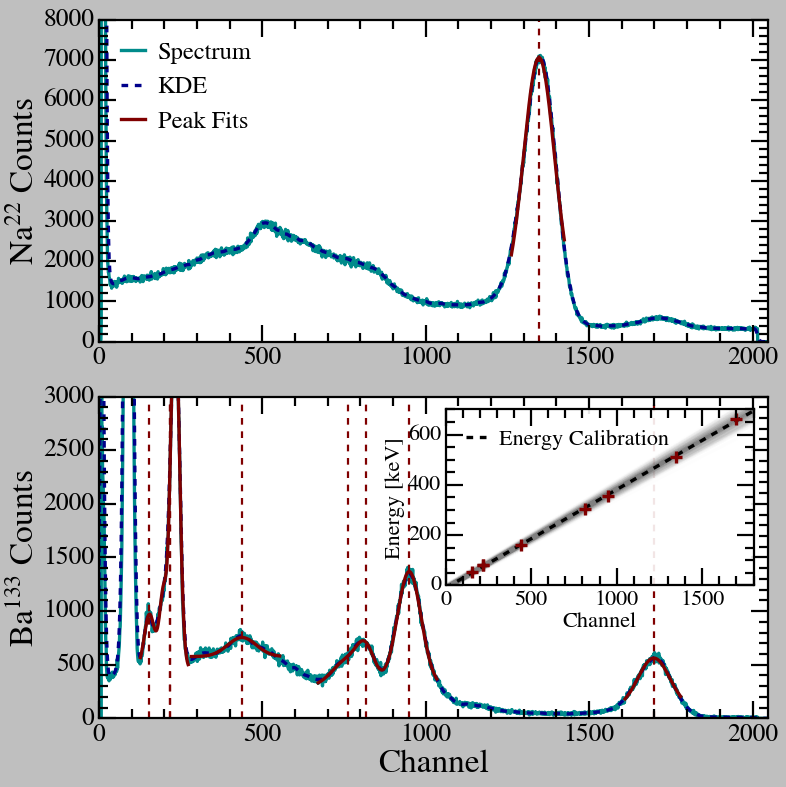

In [351]:
ylims = {
    'na': [0,8000],
    'ba': [0,3000],
}

xlabels = {
    'na': r'Na$^{22}$ Counts',
    'ba': r'Ba$^{133}$ Counts',
}

fig, axs = plt.subplots(2,1,figsize=(10, 10))

# fig.add_subplot((0.15,0.75,0.35,0.2))
# fig.add_subplot((0.60,0.28,0.35,0.2))

sub_ax = fig.add_subplot((0.565,0.26,0.385,0.22))

for i, isotope in enumerate(['na','ba']):
    show_calibration_spectrum(axs[i],sub_ax=sub_ax,
                              isotope=isotope,
                              ylim=ylims[isotope],
                              xlabel=xlabels[isotope])

plt.tight_layout()
plt.savefig('report/Figures/energy_calibration.png')

plt.show()

In [352]:
DataReader = utils.MCAData()

bins, counts, _, _ = DataReader._read_data('data/2025-03-04/scatter_0_0304.Spe')
count_normalizing_factor = np.sum(counts) * (bins[1] - bins[0])
kde_bins, kdes, kdes_err = DataReader._kde_smooth_data(bins, counts, bw=5)
peaks_idx, valleys_idx = DataReader._find_peaks_and_valleys(kde_bins, kdes, kdes_err)

approx_peak_idx = peaks_idx[
    np.argmin(np.abs(bins[peaks_idx] - 1400))
]
approx_peak_bin = bins[approx_peak_idx]
approx_peak_kde = kdes[approx_peak_idx]

lower_idx, upper_idx = DataReader._get_fitting_boundaries(bins,kdes,peaks_idx,valleys_idx,
                                                          approx_peak_bin,approx_peak_bin,
                                                          threshold=approx_peak_kde/3,threshold_ratio=1,
                                                          outward=False)

In [353]:
compton = utils.MCACompton(data_base='0_0304.Spe',data_dir='data/2025-03-04/',)

peak_mu_count, peak_mu_count_err, peak_sigma_count, peak_sigma_count_err, \
peak_mu_energy, peak_mu_energy_err, peak_sigma_energy, peak_sigma_count_err, \
peak_fwhm_rate, peak_fwhm_rate_err, fitting_bins, fitted_counts, peak_mu_bin_deviation = compton._peak_analysis('scatter')
print(peak_mu_count, peak_mu_count_err, peak_sigma_count, peak_sigma_count_err)

[1665.30885732] [1.17974675] [67.57168714] [2.46515928]


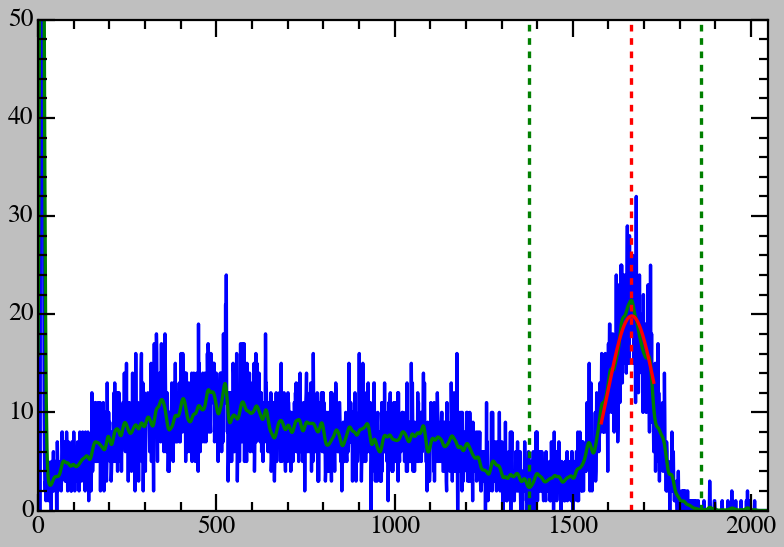

In [354]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(bins, counts)
ax.plot(kde_bins, kdes*count_normalizing_factor)
# ax.errorbar(kde_bins, kde, yerr=kde_err,
#             fmt=' s',markersize=1,elinewidth=2,capsize=5)

for peak_idx in peaks_idx:
    ax.axvline(kde_bins[peak_idx], color='r', linestyle='--')
for valley_idx in valleys_idx:
    ax.axvline(kde_bins[valley_idx], color='g', linestyle='--')

# ax.axvline(kde_bins[lower_idx], color='b', linestyle='--')
# ax.axvline(kde_bins[upper_idx], color='b', linestyle='--')

ax.plot(fitting_bins, fitted_counts, color='r')

# for fitting_bins, gaussian_counts in zip(calibration.ba_133_fitting_bins+[calibration.cs_137_fitting_bins],
#                                          calibration.ba_133_fitted_counts+[calibration.cs_137_fitted_counts]):
#     if fitting_bins is not None:
#         ax.plot(fitting_bins, gaussian_counts/count_normalizing_factor, color='r')

ax.set_xscale('linear')
# ax.set_yscale('log')

ax.set_xlim(0, 2048)
ax.set_ylim(0, 50)

plt.tight_layout()
plt.show()

In [355]:
data = {
    0 : ['0_0304.Spe','data/2025-03-04'],
    30 : ['30_0304.Spe','data/2025-03-04'],
    60 : ['60_0304.Spe','data/2025-03-04'],
    90 : ['90_0304.Spe','data/2025-03-04'],
    120 : ['120_0304.Spe','data/2025-03-04'],

    15 : ['15_0306.Spe','data/2025-03-06'],
    45 : ['45_0306.Spe','data/2025-03-06'],
    75 : ['75_0306.Spe','data/2025-03-06'],
    105 : ['105_0306.Spe','data/2025-03-06'],
    135 : ['135_0306.Spe','data/2025-03-06'],
}

In [356]:
for angle in data:
    data_file = os.path.join(data[angle][1],'scatter_'+data[angle][0])
    
    bins, counts, counting_time, total_time = DataReader._read_data(data_file)

    print(f'{angle:.0f} & {counting_time:.0f} & {total_time:.0f} & {data[angle][1][5:]} \\\\')

0 & 964 & 1012 & 2025-03-04 \\
30 & 1194 & 1224 & 2025-03-04 \\
60 & 1619 & 1658 & 2025-03-04 \\
90 & 1856 & 1900 & 2025-03-04 \\
120 & 1706 & 1736 & 2025-03-04 \\
15 & 1354 & 1522 & 2025-03-06 \\
45 & 1333 & 1455 & 2025-03-06 \\
75 & 1954 & 2058 & 2025-03-06 \\
105 & 1645 & 1727 & 2025-03-06 \\
135 & 1341 & 1431 & 2025-03-06 \\


In [357]:
angles = np.linspace(0,135,10)

electron_energies = np.array([])
electron_energies_err = np.array([])

photon_energies = np.array([])
photon_energies_err = np.array([])

scattering_rates = np.array([])
scattering_rates_err = np.array([])

for angle in angles:
    data_base, data_dir = data[angle]
    compton_data = utils.MCACompton(data_base=data_base,data_dir=data_dir)

    electron_energies = np.append(electron_energies, compton_data.recoil_peak_mu_energy)
    electron_energies_err = np.append(electron_energies_err, compton_data.recoil_peak_mu_energy_err)

    photon_energies = np.append(photon_energies, compton_data.scatter_peak_mu_energy)
    photon_energies_err = np.append(photon_energies_err, compton_data.scatter_peak_mu_energy_err)

    scattering_rates = np.append(scattering_rates, compton_data.scatter_peak_fwhm_rate)
    scattering_rates_err = np.append(scattering_rates_err, compton_data.scatter_peak_fwhm_rate_err)

    cs_137_peak_width = compton_data.cs_137_peak_width

In [423]:
class ComptonScatteringFitter(fitting.BaseFitter):
    me = 511
    p = 661.7

    def __init__(self,thetas,energies,energies_err):
        super().__init__(thetas,energies,energies_err)

    def _get_initial_guess(self):
        return [0]
    
    def _get_model(self,x,params):
        theta0 = params
        return self.p / (1 + self.p / self.me * (1 - np.cos(np.deg2rad(x + theta0))))

    def _get_model_err(self,x,params,sigma_p):
        theta0 = params
        p_prime = self._get_model(x,params)
        return 2 * sigma_p/self.p * p_prime

In [424]:
def show_total_energy(ax):
    ax.errorbar(angles, photon_energies+electron_energies, yerr=np.sqrt(photon_energies_err**2 + electron_energies_err**2), 
                fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, color='darkblue', zorder=-1)

    ax.axhline(661.7, color='darkcyan', linestyle='--', zorder=-2)
    ax.axhspan(661.7*(1-cs_137_peak_width/2), 661.7*(1+cs_137_peak_width/2), hatch='//', color='darkcyan', alpha=0.2, zorder=-2)

    ax.set_xlim(-5, 140)
    ax.set_ylim(600,700)

    ax.set_ylabel(r'$E_\gamma^\prime + E_e$ [keV]')

def show_scatter_and_recoil_energy(ax):
    ax.errorbar(angles, photon_energies, yerr=photon_energies_err,
                fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, 
                color='maroon',label=r'$E_\gamma^\prime$')
    ax.errorbar(angles, electron_energies, yerr=electron_energies_err, 
                fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, 
                color='chocolate',label=r'$E_e$')
    
    compton_fitter = ComptonScatteringFitter(angles,photon_energies,photon_energies_err)
    fitting_result = compton_fitter.fit()
    print(fitting_result)
    dense_angles, dense_photo_energies = compton_fitter.model_interpolation(params=fitting_result['params'])
    dense_photo_energies_err = compton_fitter._get_model_err(x=dense_angles,params=fitting_result['params'],sigma_p=cs_137_peak_width/2*compton_fitter.p)

    ax.plot(dense_angles, dense_photo_energies, color='maroon', linestyle='--')
    ax.plot(dense_angles, compton_fitter.p - dense_photo_energies, color='chocolate', linestyle='--')

    ax.fill_between(dense_angles, dense_photo_energies-dense_photo_energies_err, dense_photo_energies+dense_photo_energies_err, color='maroon', alpha=0.2)
    ax.fill_between(dense_angles, compton_fitter.p - dense_photo_energies-dense_photo_energies_err, compton_fitter.p - dense_photo_energies+dense_photo_energies_err, color='chocolate', alpha=0.2)
    
    ax.set_xlim(-5, 140)
    ax.set_ylim(0, 700)

    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel('Energy [keV]')

    ax.legend(loc='center left', frameon=False, fontsize=22, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

    ax_extra = ax.twinx()
    ax_extra.errorbar([1000], [1000], yerr=[1000], 
                      fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, 
                      color='black', label='Experimental Data')
    ax_extra.plot([1000], [1000], color='black', linestyle='--', zorder=-2, label='Compton Prediction')
    ax_extra.legend(loc='upper right', frameon=False, fontsize=22, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)
    ax_extra.set_yticks([])
    ax.tick_params(axis='both', which='both',direction='in',top=True,right=True)

{'params': array([-3.22576234]), 'e_params': array([0.44177975]), 'chisqr': 12.27029261476352, 'alpha': 0.19849686118140142, 'cov': array([[0.19516935]]), 'success': True, 'message': '`ftol` termination condition is satisfied.'}


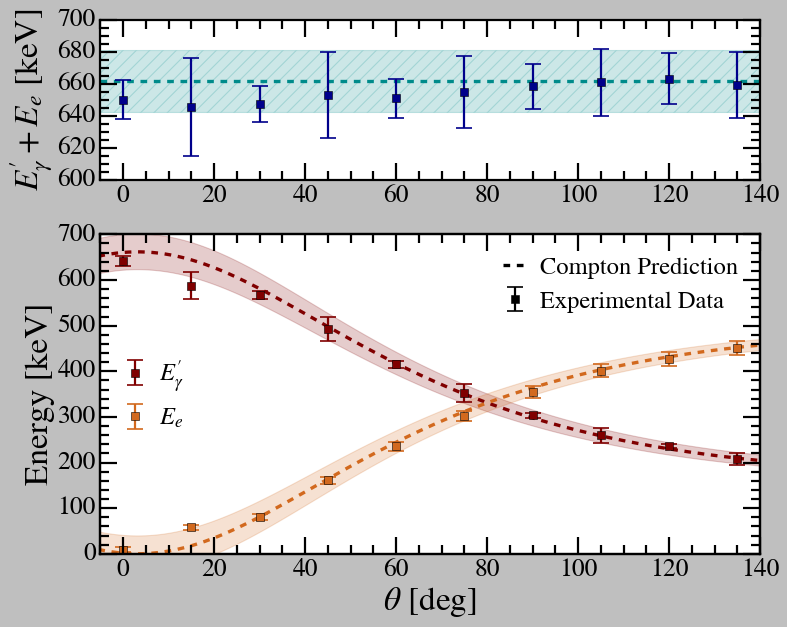

In [425]:
fig, axs = plt.subplots(2,1,figsize=(10,8),height_ratios=[0.5,1])

show_total_energy(axs[0])
show_scatter_and_recoil_energy(axs[1])

plt.tight_layout()
plt.savefig('report/Figures/energy_angle_dependency.png')

plt.show()

In [428]:
class ThompsonScatteringFitter(fitting.BaseFitter):
    def __init__(self,thetas,scattering_rates,scattering_rates_err):
        super().__init__(thetas,scattering_rates,scattering_rates_err)

    def _get_initial_guess(self):
        return [1]
    
    def _get_model(self,x,params):
        I = params
        return I * (1 + np.cos(np.deg2rad(x))**2)

{'params': array([2.15045987]), 'e_params': array([0.01403862]), 'chisqr': 6.546663120526708, 'alpha': 0.3648103724083622, 'cov': array([[0.00019708]]), 'success': True, 'message': '`ftol` termination condition is satisfied.'}


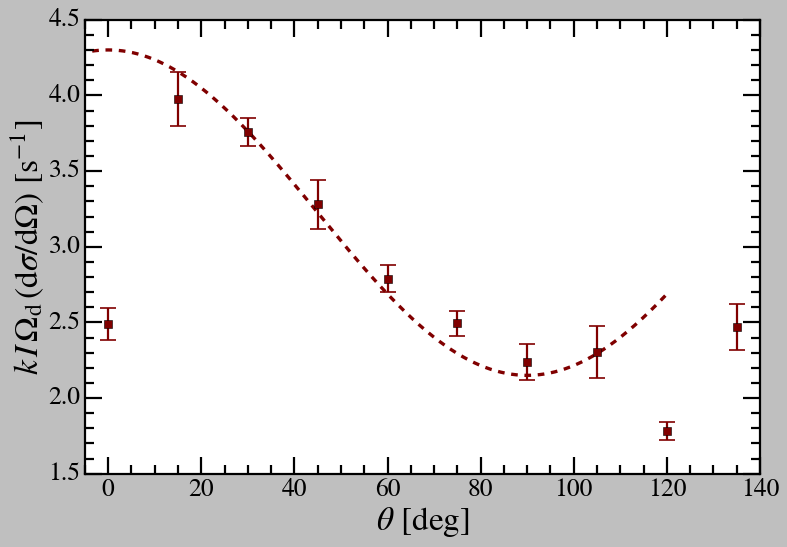

In [433]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.errorbar(angles, scattering_rates, yerr=scattering_rates_err, 
            fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, 
            color='maroon')

theta0 = ComptonScatteringFitter(angles,photon_energies,photon_energies_err).fit()['params'][0]
thompson_fitter = ThompsonScatteringFitter(angles[1:-2]+theta0,scattering_rates[1:-2],scattering_rates_err[1:-2])
fitting_result = thompson_fitter.fit()
print(fitting_result)

dense_angles, dense_scattering_rates = thompson_fitter.model_interpolation(params=fitting_result['params'])
ax.plot(dense_angles, dense_scattering_rates, color='maroon', linestyle='--')

ax.set_xlim(-5, 140)
ax.set_ylim(1.5, 4.5)

ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$k \, I \, \Omega_{\rm{d}} \, \left({\rm{d}} \sigma / {\rm{d}} \Omega\right)$ [s$^{-1}$]')

plt.tight_layout()
plt.show()